In [2]:
#! pip install tqdm
# !  pip install keras

In [3]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import string

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import load_model

import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.python.client import device_lib

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

device_lib.list_local_devices()
tf.config.list_physical_devices('GPU')


[]

# Initialization

In [5]:
char_list = string.ascii_letters+string.digits
characters = set(char for char in char_list)
characters = sorted(list(characters))
img_height = 50
img_width = 200
vocab_len = len(characters)
# Map text to numeric labels 
char_to_num = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
num_to_char = {val:key for key, val in char_to_num.items()}

# Processing raw data

In [6]:
def raw_data_process(path):
    path = Path(path)
    images = sorted(list(map(str, list(path.glob("*.png")))))
    #split labels
    labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

    max_length = max([len(label) for label in labels])
    for i, label in enumerate(labels):
        if len(label) > 5:
            print(f"{i} {label}")
            print(images[i])

    print("Number of images found: ", len(images))
    print("Number of labels found: ", len(labels))
    print("Maximum label length: ",max_length)
    return images, labels, max_length



# Text Captcha preprocessing and normalization


Dictionary for mapping text character and numerical label

In [7]:
# Map text to numeric labels 
char_to_num = {char:idx for idx, char in enumerate(characters)}

# Map numeric labels to text
num_to_char = {val:key for key, val in char_to_num.items()}

Standardize and normalize image and input data for model

In [8]:
def images_process(images, labels,img_height, img_width):
    #input images path file and corresponding label
    #return matrix of grayscale img and encoded numerical labels


    def is_valid_captcha(captcha):
        for ch in captcha:
            if not ch in characters:
                return False
        return True
        
    #encode text label to list of number
    def encode_to_label(label):
        label = list(map(lambda x:char_to_num[x], label))
        return label

    def read_image(path, resize = True):

        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        if resize:
            img = cv2.resize(img, (img_width,img_height)) #standardize image

        img = (img/255).astype(np.float32) 
        img = img.T #transpose image, timestep will fit to the width of image
        return img
        
    def prep_data(images, labels):
        X = [read_image(img) for img in images] #pre-processing image
        y = [encode_to_label(label) for label in labels] #encode text label to numerical
        y = np.array(y)
        X = np.array(X)

        return X,y

    img, labels = prep_data(images,labels)
    return img, labels

In [9]:
data_dir = "samples" #replace by path to dataset
images, labels, max_length = raw_data_process(data_dir) #get raw data

X, y = images_process(images, labels,img_height,img_width)
# print(X[:10])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1, shuffle = True)
y_train = pad_sequences(y_train, maxlen=max_length, padding='post', value = len(characters))
y_test = pad_sequences(y_test, maxlen=max_length, padding='post', value = len(characters))
print(X_train.shape)

print(y_train.shape)


Number of images found:  1040
Number of labels found:  1040
Maximum label length:  5
(832, 200, 50)
(832, 5)


# Visualization

(-0.5, 49.5, 199.5, -0.5)

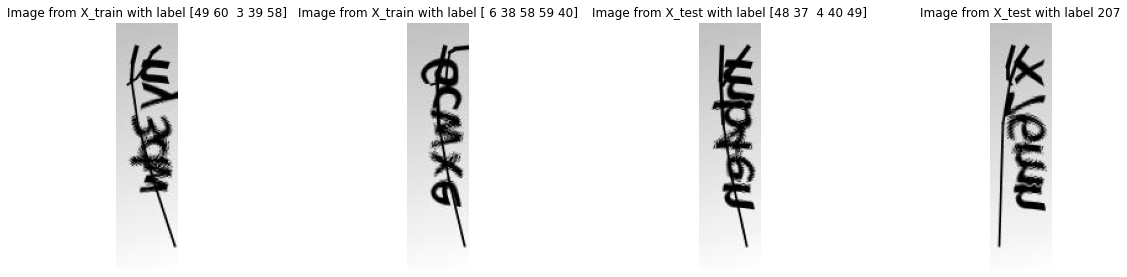

In [10]:


fig=plt.figure(figsize=(20, 10))
fig.add_subplot(2, 4, 1)
plt.imshow(X_train[0], cmap='gray')
#plt.imshow(X_train[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[0]))
plt.axis('off')
fig.add_subplot(2, 4, 2)
plt.imshow(X_train[len(X_train)-1], cmap='gray')
#plt.imshow(X_train[935].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_train with label '+ str(y_train[len(X_train)-1]))
plt.axis('off')
fig.add_subplot(2, 4, 3)
plt.imshow(X_test[0], cmap='gray')
#plt.imshow(X_test[0].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_test with label '+ str(y_test[0]))
plt.axis('off')
fig.add_subplot(2, 4, 4)
plt.imshow(X_test[len(X_test)-1], cmap='gray')
#plt.imshow(X_test[103].transpose((1,0,2)), cmap='gray')
plt.title('Image from X_test with label '+ str(len(X_test)-1))
plt.axis('off')



# CNN model


In [11]:
downsample_factor = 8 #pool size =2 with 4 pooling layers
def build_cnn_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name ="input_data", dtype = "float32")
    labels = layers.Input(name = "input_label", shape = (max_length,), dtype="float32")

    #Conv Layers
    conv_1 = layers.Conv2D(32, (3,3), 
                            activation= "relu", 
                            kernel_initializer="he_normal", 
                            padding = "same", 
                            name = "Conv1")(input_img)
    pool_1 = layers.MaxPooling2D((2,2), name = "pool1")(conv_1)

    conv_2 = layers.Conv2D(64, (3,3), activation= "relu", kernel_initializer="he_normal", padding = "same", name = "Conv2")(pool_1)
    pool_2 = layers.MaxPooling2D((2,2), name = "pool2")(conv_2)

    conv_3 = layers.Conv2D(120, (3,3), activation= "relu", kernel_initializer="he_normal", padding = "same", name = "Conv3")(pool_2)
    conv_3 = layers.Dropout(0.2)(conv_3) #drop connection with ratio 0.2 to avoid overfitting
    pool_3 = layers.MaxPooling2D((2,2), name = "pool3")(conv_3)

    # conv_4 = layers.Conv2D(256, (3,3), activation= "relu", kernel_initializer="he_normal", padding = "same", name = "Conv4")(pool_3)
    # batch_norm_4 = layers.BatchNormalization()(conv_4)
    # pool_4 = layers.MaxPooling2D((2,2), name = "pool4")(batch_norm_4)

    # Reshape layer for RNN input
    new_shape = ((img_width //downsample_factor),(img_height // downsample_factor)*120)
    reshape = layers.Reshape(target_shape=(max_length,new_shape[1]*new_shape[0]//max_length), name = "reshape")(pool_3)
    dense_1 = layers.Dense(256, activation= "relu", name = "dense_1") (reshape) #FC layer
    dense_1 = layers.Dropout(0.2)(dense_1)
    dense_2 = layers.Dense(128, activation= "relu", name = "dense_2") (dense_1) #FC layer

    # conv_encoder = layers.Dropout(0.2)(conv_encoder) #drop connection with ratio 0.2 to avoid overfitting

    #Single CNN model 
    output = layers.Dense(vocab_len, activation= "softmax", name ="CNN_output")(dense_2)
    cnn_model = keras.models.Model(inputs = input_img, outputs = output, name = "CNN_model")
    cnn_model.compile(optimizer = keras.optimizers.Adam(), loss="sparse_categorical_crossentropy", metrics = "accuracy")
    return cnn_model
cnn_model = build_cnn_model()
cnn_model.summary()



Model: "CNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 12, 120)       69240     
                                                                 
 dropout (Dropout)           (None, 50, 12, 120)       0 

In [12]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

print (y_train[:3])

history = cnn_model.fit(x = X_train, y = y_train, validation_data=(X_test, y_test), epochs=60, batch_size = 32, callbacks = [early_stopping])

[[49 60  3 39 58]
 [58  8 41  3  6]
 [ 6 51 41 60  4]]
Epoch 1/60
26/26 [==============================] - 9s 287ms/step - loss: 3.3677 - accuracy: 0.0745 - val_loss: 3.0200 - val_accuracy: 0.0981
Epoch 2/60
26/26 [==============================] - 8s 303ms/step - loss: 2.9034 - accuracy: 0.1168 - val_loss: 2.7399 - val_accuracy: 0.2010
Epoch 3/60
26/26 [==============================] - 9s 354ms/step - loss: 2.5655 - accuracy: 0.2325 - val_loss: 2.3299 - val_accuracy: 0.3500
Epoch 4/60
26/26 [==============================] - 15s 593ms/step - loss: 2.1208 - accuracy: 0.3805 - val_loss: 1.9290 - val_accuracy: 0.4500
Epoch 5/60
26/26 [==============================] - 26s 1s/step - loss: 1.7647 - accuracy: 0.4774 - val_loss: 1.6895 - val_accuracy: 0.4971
Epoch 6/60
26/26 [==============================] - 24s 905ms/step - loss: 1.5509 - accuracy: 0.5356 - val_loss: 1.5190 - val_accuracy: 0.5577
Epoch 7/60
26/26 [==============================] - 13s 483ms/step - loss: 1.3969 - accuracy:

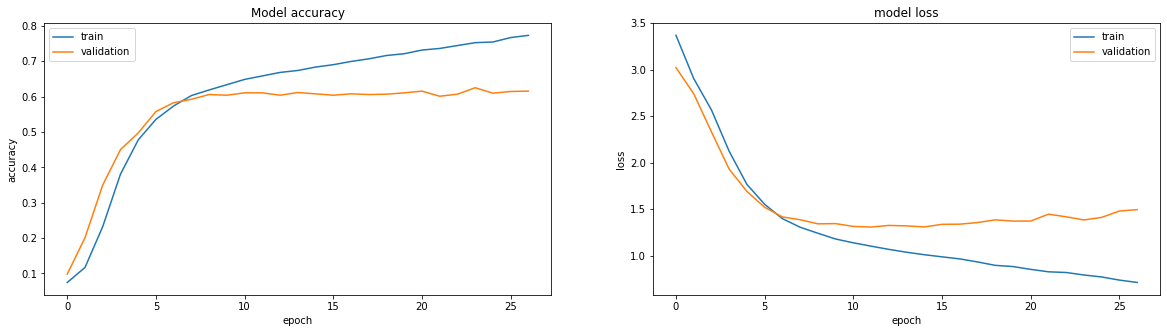

In [13]:
fig=plt.figure(figsize=(20, 5))
# summarize history for accuracy
fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])

# summarize history for loss
fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

# CRNN model with CTC loss layer

In [14]:
#Customize CTC layer for output
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return loss



In [15]:
downsample_factor = 8 #pool size =2 with 3 pooling layers
def build_model():
    input_img = layers.Input(shape=(img_width,img_height, 1), name ="input_data", dtype = "float32")
    labels = layers.Input(name = "input_label", shape = max_length, dtype="float32")

    #Conv Layers
    conv_1 = layers.Conv2D(32, (3,3), 
                            activation= "relu", 
                            kernel_initializer="he_normal", 
                            padding = "same", 
                            name = "Conv1")(input_img)
    pool_1 = layers.MaxPooling2D((2,2), name = "pool1")(conv_1)

    conv_2 = layers.Conv2D(64, (3,3), activation= "relu", kernel_initializer="he_normal", padding = "same", name = "Conv2")(pool_1)
    pool_2 = layers.MaxPooling2D((2,2), name = "pool2")(conv_2)

    conv_3 = layers.Conv2D(128, (3,3), activation= "relu", kernel_initializer="he_normal", padding = "same", name = "Conv3")(pool_2)
    conv_3 = layers.Dropout(0.2)(conv_3) #drop connection with ratio 0.2 to avoid overfitting
    pool_3 = layers.MaxPooling2D((2,2), name = "pool3")(conv_3)

    # 3 maxpooling layers with stride = 2
    # Which leads to 8x smaller downsampled feature maps
    # Flatten the last conv_3 layer with 128 filters in to a feature vector and go through a Fully-Connected NN 
    # to summarize the learning features and being used as input for classification stage (RNN)
    new_shape = ((img_width //downsample_factor),(img_height // downsample_factor)*128)
    reshape = layers.Reshape(target_shape=new_shape, name = "reshape")(pool_3)
    #Fully-connected network
    dense_1 = layers.Dense(128, activation= "relu", name = "dense_1") (reshape) #FC layer
    dense_2 = layers.Dense(64, activation= "relu", name = "dense_2") (dense_1) #FC layer
    dense_2 = layers.Dropout(0.2)(dense_2)
    conv_encoder = layers.Dense(64, activation= "relu", name = "cnn_encoder") (dense_2) #FC layer
    conv_encoder = layers.Dropout(0.2)(conv_encoder) #drop connection with ratio 0.2 to avoid overfitting

    #RNNs
    lstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.02))(conv_encoder)
    lstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.2))(lstm_1)
    #transcipt layer
    prediction = layers.Dense(vocab_len + 1, activation="softmax", name = "pred")(lstm_2)
    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, prediction)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1")
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

model = build_model()
print(model.input)
model.summary()

[<KerasTensor: shape=(None, 200, 50, 1) dtype=float32 (created by layer 'input_data')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'input_label')>]
Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_data (InputLayer)        [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['input_data[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                   

In [16]:
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
# print ([X_train, y_train])
# Train the model
train = [X_train, y_train]


val = [X_test, y_test]
history = model.fit( train, y = np.zeros(len(y_train)), validation_data=([X_test, y_test],np.zeros(len(y_test))), epochs=150, callbacks=[early_stopping])
# history = model.fit( train, validation_data=[X_test, y_test], epochs=100, callbacks=[early_stopping])

Epoch 1/150
26/26 [==============================] - 33s 709ms/step - loss: 27.1140 - val_loss: 17.7088
Epoch 2/150
26/26 [==============================] - 12s 472ms/step - loss: 16.8615 - val_loss: 16.4919
Epoch 3/150
26/26 [==============================] - 13s 492ms/step - loss: 16.4377 - val_loss: 16.4244
Epoch 4/150
26/26 [==============================] - 13s 480ms/step - loss: 16.3569 - val_loss: 16.3695
Epoch 5/150
26/26 [==============================] - 14s 528ms/step - loss: 16.3373 - val_loss: 16.3741
Epoch 6/150
26/26 [==============================] - 11s 439ms/step - loss: 16.3275 - val_loss: 16.3197
Epoch 7/150
26/26 [==============================] - 9s 334ms/step - loss: 16.3154 - val_loss: 16.3598
Epoch 8/150
26/26 [==============================] - 9s 342ms/step - loss: 16.3012 - val_loss: 16.3166
Epoch 9/150
26/26 [==============================] - 8s 313ms/step - loss: 16.3005 - val_loss: 16.3258
Epoch 10/150
26/26 [==============================] - 8s 297ms/step

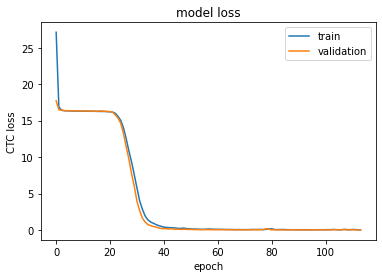

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('CTC loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [18]:
# model.save('./MyModel_tf',save_format='tf')


# loading the saved model
loaded_model = tf.keras.models.load_model('./Text_Captcha_Pretrained_model_tf')

In [19]:
prediction_model = keras.models.Model(
    loaded_model.get_layer(name="input_data").input, loaded_model.get_layer(name="pred").output
)
prediction_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_data (InputLayer)     [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Conv3 (Conv2D)              (None, 50, 12, 128)       73856     
                                                                 
 dropout_2 (Dropout)         (None, 50, 12, 128)       0     

In [20]:
def decode_to_text(output):
    text_label = ""
    for c in output:
        if c in num_to_char:
            text_label += num_to_char[c]

    return text_label
def decode_model_output(y_pred):
    result = keras.backend.ctc_decode(y_pred, 
                                        input_length=np.ones(y_pred.shape[0])*y_pred.shape[1],
                                        greedy=True)[0][0][:,:max_length] 
    labels = []
    for output in result.numpy():
        labels.append(decode_to_text(output))

    return labels


y_pred = prediction_model.predict(X_test) # y_pred shape = (104,50,20)
label_pred = decode_model_output(y_pred)
for i in range(len(X_test)):
    image = X_test[i]
    label_truth = decode_to_text(y_test[i])
    
    print(f'Ground truth: {label_truth} \t Predicted: {label_pred[i]}')



7/7 [==============================] - 2s 61ms/step
Ground truth: mb4en 	 Predicted: mb4en
Ground truth: cb8cf 	 Predicted: cb8cf
Ground truth: n336e 	 Predicted: n336e
Ground truth: f5e5e 	 Predicted: f5e5e
Ground truth: 3eny7 	 Predicted: 3eny7
Ground truth: xdcn4 	 Predicted: xdcn4
Ground truth: 5npdn 	 Predicted: 5npdn
Ground truth: bgem5 	 Predicted: bgem5
Ground truth: gxx2p 	 Predicted: gxx2p
Ground truth: 5n245 	 Predicted: 5n245
Ground truth: 8c23f 	 Predicted: 8c23f
Ground truth: 8fexn 	 Predicted: 8fexn
Ground truth: 3xcgg 	 Predicted: 3xcgg
Ground truth: dyxnc 	 Predicted: dyxnc
Ground truth: d75b5 	 Predicted: d75b5
Ground truth: e6b7y 	 Predicted: e6b7y
Ground truth: 74853 	 Predicted: 74853
Ground truth: x5nyn 	 Predicted: x5nyn
Ground truth: 6xen4 	 Predicted: 6xen4
Ground truth: 32dnn 	 Predicted: 32dnn
Ground truth: 2nf26 	 Predicted: 2nf26
Ground truth: g7wxw 	 Predicted: g7wxw
Ground truth: ncyx8 	 Predicted: ncyx8
Ground truth: x7547 	 Predicted: x7547
Ground truth

In [21]:
model.save('partly_trained_2.h5')
